# Exploratory Data Analysis

This notebook loads and explores the three CSVs in `data/` for basic structure, missingness, distributions, and quick cross-tabs.

In [395]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:0.2f}")

In [396]:
data_dir = Path("..") / "data"
players_path = data_dir / "players.csv"
player_games_path = data_dir / "player_games.csv"
vgsales_path = data_dir / "vgsales.csv"

players = pd.read_csv(players_path)
player_games = pd.read_csv(player_games_path)
vgsales = pd.read_csv(vgsales_path)

players.shape, player_games.shape, vgsales.shape


((11959, 6), (59795, 9), (16598, 11))

## Players
- Demographics and session behavior by `age_group`.
- Look at missingness, distribution of sessions per week, and session length.

In [397]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   11959 non-null  int64  
 1   age_group                 11959 non-null  object 
 2   session_count_per_week    11959 non-null  int64  
 3   avg_session_length_hours  11959 non-null  float64
 4   primary_genre             11959 non-null  object 
 5   preferred_platform        11959 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 560.7+ KB


In [398]:
players.describe(include="all")

user_id age_group  session_count_per_week  avg_session_length_hours  \
count  11959.00     11959                11959.00                  11959.00   
unique      NaN         3                     NaN                       NaN   
top         NaN      Teen                     NaN                       NaN   
freq        NaN      5924                     NaN                       NaN   
mean    5980.00       NaN                    5.65                      2.01   
std     3452.41       NaN                    3.30                      0.69   
min        1.00       NaN                    2.00                      0.50   
25%     2990.50       NaN                    3.00                      1.54   
50%     5980.00       NaN                    5.00                      2.01   
75%     8969.50       NaN                    7.00                      2.48   
max    11959.00       NaN                   14.00                      4.61   

       primary_genre preferred_platform  
count          11959              11959  
unique            12                 25  
top           Action                 DS  
freq            2394               2286  
mean             NaN                NaN  
std              NaN                NaN  
min              NaN                NaN  
25%              NaN                NaN  
50%              NaN                NaN  
75%              NaN                NaN  
max              NaN                NaN

In [399]:
players['age_group'].value_counts()

age_group
Teen     5924
Adult    3646
Kids     2389
Name: count, dtype: int64

In [400]:
players.groupby('age_group')[['session_count_per_week', 'avg_session_length_hours']].agg(['mean','median','min','max'])

session_count_per_week                avg_session_length_hours  \
                            mean median min max                     mean   
age_group                                                                  
Adult                       5.70   5.00   2  14                     2.03   
Kids                        5.69   5.00   2  14                     2.01   
Teen                        5.60   5.00   2  14                     2.01   

                            
          median  min  max  
age_group                   
Adult       2.03 0.50 4.32  
Kids        2.01 0.50 4.60  
Teen        2.00 0.50 4.61

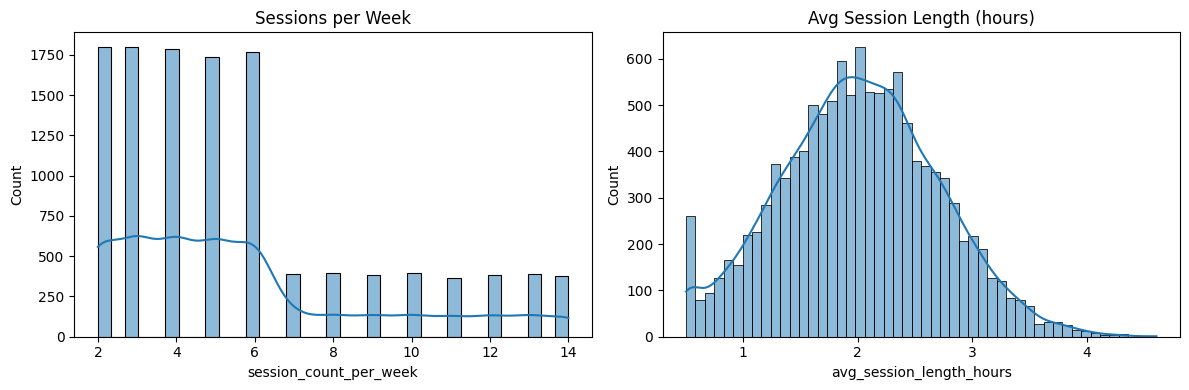

In [401]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(players['session_count_per_week'], kde=True, ax=axes[0])
axes[0].set_title('Sessions per Week')
sns.histplot(players['avg_session_length_hours'], kde=True, ax=axes[1])
axes[1].set_title('Avg Session Length (hours)')
plt.tight_layout()

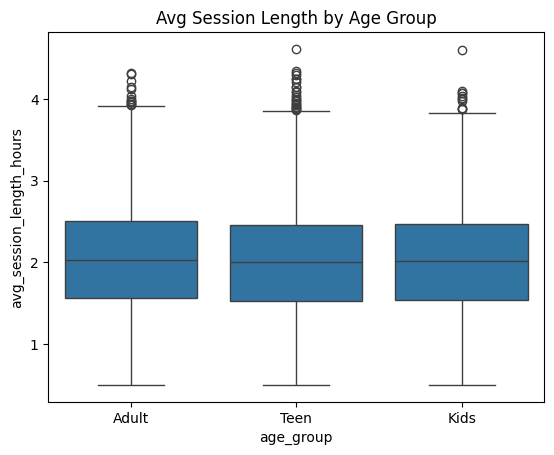

In [ ]:
# Visualizing session count per week by age group
sns.boxplot(x='age_group', y='avg_session_length_hours', data=players)
plt.title('Avg Session Length by Age Group')
plt.show()

## Player Games
- Game-level play history per user: platform/genre splits, playtime, price vs rating.

In [402]:
player_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59795 entries, 0 to 59794
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         59795 non-null  int64  
 1   game_title      59795 non-null  object 
 2   platform        59795 non-null  object 
 3   genre           59795 non-null  object 
 4   release_year    58812 non-null  float64
 5   publisher       59584 non-null  object 
 6   global_sales    59795 non-null  float64
 7   playtime_hours  59795 non-null  float64
 8   player_rating   59795 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 4.1+ MB


In [403]:
player_games.describe(include='all')

user_id           game_title platform   genre  release_year  \
count  59795.00                59795    59795   59795      58812.00   
unique      NaN                11492       31      12           NaN   
top         NaN  LEGO Jurassic World       DS  Action           NaN   
freq        NaN                   35     7891   11970           NaN   
mean    5980.00                  NaN      NaN     NaN       2006.42   
std     3452.29                  NaN      NaN     NaN          5.81   
min        1.00                  NaN      NaN     NaN       1980.00   
25%     2990.00                  NaN      NaN     NaN       2003.00   
50%     5980.00                  NaN      NaN     NaN       2007.00   
75%     8970.00                  NaN      NaN     NaN       2010.00   
max    11959.00                  NaN      NaN     NaN       2020.00   

              publisher  global_sales  playtime_hours  player_rating  
count             59584      59795.00        59795.00       59795.00  
unique              578           NaN             NaN            NaN  
top     Electronic Arts           NaN             NaN            NaN  
freq               4863           NaN             NaN            NaN  
mean                NaN          0.54            6.04           2.95  
std                 NaN          1.61            4.46           0.75  
min                 NaN          0.01            0.50           1.00  
25%                 NaN          0.06            3.46           2.43  
50%                 NaN          0.17            5.28           2.93  
75%                 NaN          0.47            7.27           3.45  
max                 NaN         82.74           40.70           5.00

In [404]:
player_games[['platform','genre','release_year']].nunique()


platform        31
genre           12
release_year    39
dtype: int64

In [405]:
player_games['platform'].value_counts().head()

platform
DS      7891
PS2     7841
PS3     4790
Wii     4741
X360    4549
Name: count, dtype: int64

In [406]:
player_games['genre'].value_counts().head()

genre
Action          11970
Sports           8490
Misc             6290
Role-Playing     5410
Shooter          4675
Name: count, dtype: int64

In [407]:
player_games[['platform','genre']].value_counts().head()


platform  genre 
PS2       Sports    1451
DS        Misc      1442
PS3       Action    1355
PS2       Action    1285
DS        Action    1242
Name: count, dtype: int64

In [408]:
player_games[['global_sales','player_rating','playtime_hours']].corr()


global_sales  player_rating  playtime_hours
global_sales            1.00           0.00           -0.01
player_rating           0.00           1.00            0.27
playtime_hours         -0.01           0.27            1.00

In [409]:
player_games.groupby('platform')['playtime_hours'].mean().sort_values(ascending=False).head()

platform
DS     7.14
PS2    7.14
PS3    6.04
Wii    6.03
X360   6.00
Name: playtime_hours, dtype: float64

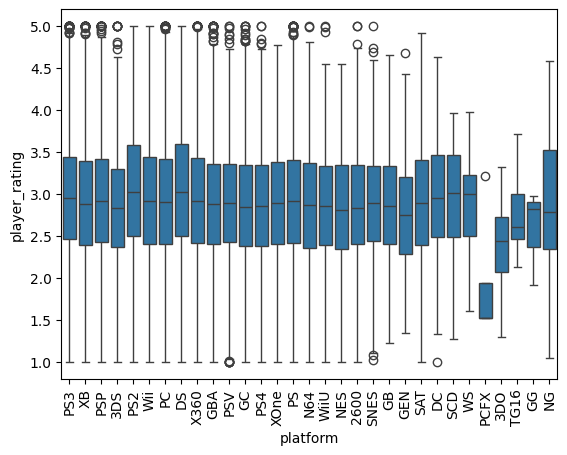

In [431]:
# Looking at a box plot of platform and player rating
sns.boxplot(data=player_games, x='platform', y='player_rating')
# rotate x labels for better readability
plt.xticks(rotation=90)
plt.show()

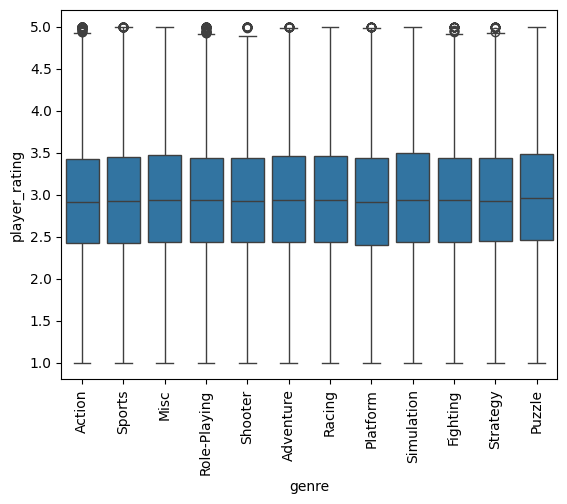

In [432]:
# Doing the same for genre and player rating
sns.boxplot(data=player_games, x='genre', y='player_rating')
plt.xticks(rotation=90)
plt.show()

## Video Game Sales
- Global sales by platform/genre; missingness in `Year` and `Publisher`; sales trends over years.

In [411]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [412]:
vgsales.isna().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [413]:
vgsales.describe(include='all')

Rank                         Name Platform     Year   Genre  \
count  16598.00                        16598    16598 16327.00   16598   
unique      NaN                        11493       31      NaN      12   
top         NaN  Need for Speed: Most Wanted       DS      NaN  Action   
freq        NaN                           12     2163      NaN    3316   
mean    8300.61                          NaN      NaN  2006.41     NaN   
std     4791.85                          NaN      NaN     5.83     NaN   
min        1.00                          NaN      NaN  1980.00     NaN   
25%     4151.25                          NaN      NaN  2003.00     NaN   
50%     8300.50                          NaN      NaN  2007.00     NaN   
75%    12449.75                          NaN      NaN  2010.00     NaN   
max    16600.00                          NaN      NaN  2020.00     NaN   

              Publisher  NA_Sales  EU_Sales  JP_Sales  Other_Sales  \
count             16540  16598.00  16598.00  16598.00     16598.00   
unique              578       NaN       NaN       NaN          NaN   
top     Electronic Arts       NaN       NaN       NaN          NaN   
freq               1351       NaN       NaN       NaN          NaN   
mean                NaN      0.26      0.15      0.08         0.05   
std                 NaN      0.82      0.51      0.31         0.19   
min                 NaN      0.00      0.00      0.00         0.00   
25%                 NaN      0.00      0.00      0.00         0.00   
50%                 NaN      0.08      0.02      0.00         0.01   
75%                 NaN      0.24      0.11      0.04         0.04   
max                 NaN     41.49     29.02     10.22        10.57   

        Global_Sales  
count       16598.00  
unique           NaN  
top              NaN  
freq             NaN  
mean            0.54  
std             1.56  
min             0.01  
25%             0.06  
50%             0.17  
75%             0.47  
max            82.74

In [414]:
vgsales['Platform'].value_counts().head()

Platform
DS      2163
PS2     2161
PS3     1329
Wii     1325
X360    1265
Name: count, dtype: int64

In [415]:
vgsales['Genre'].value_counts().head()

Genre
Action          3316
Sports          2346
Misc            1739
Role-Playing    1488
Shooter         1310
Name: count, dtype: int64

In [416]:
vgsales.groupby('Platform')['Global_Sales'].median().sort_values(ascending=False).head()

Platform
NES    1.38
GB     1.17
2600   0.46
SNES   0.32
X360   0.28
Name: Global_Sales, dtype: float64

In [417]:
annual_sales = vgsales.dropna(subset=['Year']).groupby('Year')['Global_Sales'].mean()
annual_sales.tail()

Year
2014.00   0.58
2015.00   0.43
2016.00   0.21
2017.00   0.02
2020.00   0.29
Name: Global_Sales, dtype: float64

/var/folders/ps/dp2pv5c94mgd208r06lxs13r0000gn/T/ipykernel_2141/816246375.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


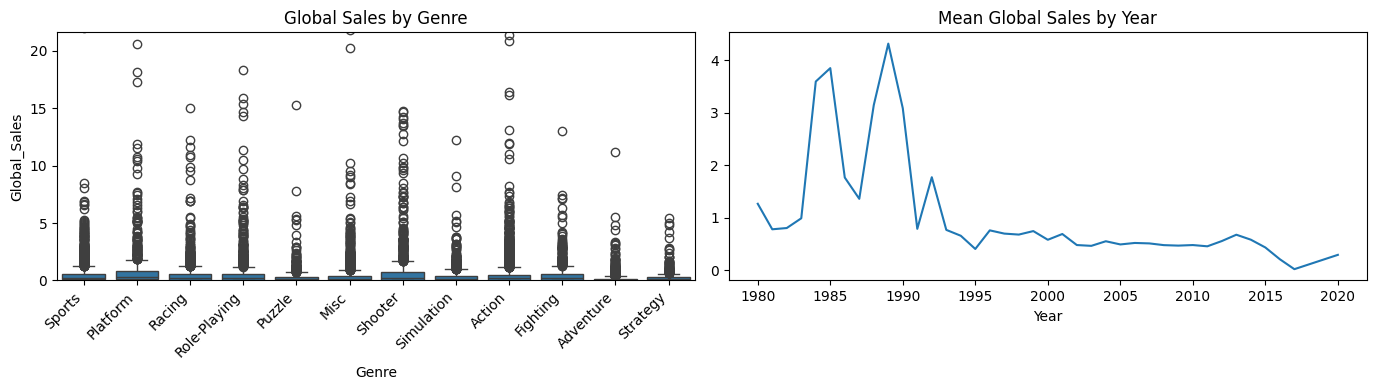

In [418]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.boxplot(data=vgsales, x='Genre', y='Global_Sales', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_ylim(0, annual_sales.max()*5)
axes[0].set_title('Global Sales by Genre')
annual_sales.plot(ax=axes[1])
axes[1].set_title('Mean Global Sales by Year')
plt.tight_layout()

## Summary of EDA and Preprocessing Work
- Loaded three datasets from `data/` (`players`, `player_games`, `vgsales`).
- Explored each dataset: `info()`, `describe()`, value counts, grouped stats, correlations, and several plots (histograms/boxplots/scatter/trend lines).



## Part 1: Recommendation System with Surprise
- Answering part 1 of the final project, which is to recommend games to players based on their past play history. For simplicity, I'll use collaborative filtering with the `Surprise` library using ratings derived from players.


In [419]:
# First, I need to filter down to a data frame with three columns for this model:
# UserID, Game Title, and user rating.
# The player_games csv has those three columns, so I'll go ahead and grab it.
model_df = pd.read_csv("../data/player_games.csv")
cols_to_keep = ['user_id', 'game_title', 'player_rating']

rating_df = model_df[cols_to_keep]

In [420]:
# Using surprise
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(rating_df, reader)

algo = SVD()

# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7664  0.7729  0.7703  0.7756  0.7817  0.7734  0.0051  
MAE (testset)     0.6117  0.6165  0.6150  0.6194  0.6267  0.6179  0.0051  
Fit time          0.24    0.23    0.23    0.28    0.23    0.24    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([0.76640253, 0.77290512, 0.77033789, 0.7755744 , 0.78171088]),
 'test_mae': array([0.61169383, 0.61648458, 0.61500677, 0.61944409, 0.62674731]),
 'fit_time': (0.24348711967468262,
  0.22731304168701172,
  0.23478198051452637,
  0.27704286575317383,
  0.23459768295288086),
 'test_time': (0.022140979766845703,
  0.02116107940673828,
  0.020733118057250977,
  0.020853042602539062,
  0.02072310447692871)}

In [421]:


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [422]:
# Train the model on the full dataset
print("Training the model on the full dataset...")
trainset = data.build_full_trainset()
algo.fit(trainset)
print("Model trained.")

# Predict ratings for all pairs that are not in the training set.
print("Generating recommendations...")
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
print("Recommendations generated.")

print("Getting the top 5 recommendations for each user...")
top_n = get_top_n(predictions,n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(f"User {uid}:")
    for (iid, est) in user_ratings:
        print(f"  Game: {iid}, Estimated Rating: {est:0.2f}")
    print()


Training the model on the full dataset...
Model trained.
Generating recommendations...
Recommendations generated.
Getting the top 5 recommendations for each user...
User 1:
  Game: Silly Bandz: Play The Craze, Estimated Rating: 3.46
  Game: Disney's Kim Possible: Revenge of Monkey Fist, Estimated Rating: 3.41
  Game: Apassionata: Die Galanacht der Pferde, Estimated Rating: 3.37
  Game: Dynasty Warriors 5: Xtreme Legends, Estimated Rating: 3.37
  Game: Power Rangers: Super Legends, Estimated Rating: 3.34

User 2:
  Game: Hitman 2: Silent Assassin, Estimated Rating: 3.45
  Game: Goat Simulator, Estimated Rating: 3.43
  Game: SpongeBob's Atlantis SquarePantis, Estimated Rating: 3.43
  Game: The Testament of Sherlock Holmes, Estimated Rating: 3.42
  Game: Pokémon Platinum Version, Estimated Rating: 3.41

User 3:
  Game: Magical Starsign (US sales), Estimated Rating: 3.58
  Game: Pokémon Platinum Version, Estimated Rating: 3.53
  Game: Katekyoo Hitman Reborn! DS Flame Rumble X - Mirai Chou-